In [1]:
%load_ext autoreload

%autoreload 2

In [45]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as tfk
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from validation.metrics import OME, MSE, get_CV_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from MODELS.ViscNN import load_models, create_ViscNN_concat, create_ViscNN_phys,predict_all_cv, ViscNN_concat_HP,  create_ViscNN_phys_HP
from validation.tests import custom_train_test_split, get_Mw_samples, crossval_NN, Mw_test, evaluate_model, crossval_compare, get_shear_samples, shear_test, small_shear_test, assign_sample_ids
import keras_tuner as kt
from gpflow_tools.gpr_models import train_GPR, create_GPR
from data_tools.dim_red import fp_PCA
from data_tools.data_viz import val_epochs, calc_slopes_Mw, compare_cv
import datetime
import keras.backend as K
import keras
import random
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-02-22 09:42:10.679127: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-22 09:42:11.366955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25751 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:da:00.0, compute capability: 7.0


In [84]:
data = pd.read_excel('Data/full_data_2022-01-19_MOD.xlsx')
data.columns = [str(c) for c in data.columns]

In [85]:
shear_samps, shear_ids = get_shear_samples(data.copy())

In [86]:
Mw_samps, mw_ids = get_Mw_samples(data.copy());

In [56]:
print(len(data))
len(shear_samps) + len(Mw_samps)

1655


1240

In [57]:
data, shear_ids, Mw_ids = assign_sample_ids(data.copy())

In [58]:
OG_fp = []
for c in data.columns:
    if isinstance(c, str):
        if 'fp' in c:
            OG_fp.append(c)
len(OG_fp)

217

In [59]:
do_pca = False
if do_pca:
    data, fp_cols, pca = fp_PCA(data, 17, cols = OG_fp)
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
else:
    fp_cols = OG_fp
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']

In [60]:
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

data['ZERO_SHEAR'] = 1
data['SHEAR'] = 0
data['log_Shear_Rate'] = 0
for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        data.loc[i,'log_Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data.loc[i, 'SHEAR'] = 1
        data.loc[i, 'ZERO_SHEAR'] = 0
        #data = data.drop([i])

In [61]:
#cols.remove('Shear_Rate')
filtered_data = data.loc[:, cols + ['Polymer', 'SHEAR', 'ZERO_SHEAR', 'log_Shear_Rate', 'PDI', 'Sample_Type', 'SMILES', 'SAMPLE_ID']].dropna(subset = ['Mw', 'Shear_Rate'])
#X_tot = np.array(filtered_data.filter(fp_cols + ['SHEAR', 'ZERO_SHEAR']))


In [94]:
load_data = True
custom = False
full_data = False
date = '2022-02-22'
data_type = 'full'


if full_data:
    train_df = filtered_data.sample(frac = 1)
    test_df = filtered_data.sample(frac = 0.05) #dummy df for compatibility
else:
    if load_data:
        train_df = pd.read_pickle(f'MODELS/{date}_{data_type}/train_data.pkl')
        if data_type == 'full':
            test_df = filtered_data.sample(frac = 0.05) #dummy df for compatibility
        else:
            test_df = pd.read_pickle(f'MODELS/{date}_{data_type}/test_data.pkl')
    else: 
        if custom:
            total_samps = len(Mw_ids) + len(shear_ids)
            train_df, test_df = custom_train_test_split(filtered_data, test_id= random.sample(Mw_ids,total_samps//20) + random.sample(shear_ids,total_samps//20), id_col= 'SAMPLE_ID')
        else:
            train_df, test_df = train_test_split(filtered_data, test_size= 0.1)
        
        train_df = train_df.loc[:, (train_df != 0).any(axis=0)]
        new_fp = []
        for c in train_df.columns:
            if isinstance(c, str):
                if 'fp' in c:
                    new_fp.append(c)

        if len(OG_fp) != len(new_fp):
            test_df = test_df.drop(columns = list(set(OG_fp) - set(new_fp)))
print(len(train_df))
print(len(test_df))

1617
81


In [95]:
logMw = np.array(train_df['Mw']).reshape((-1,1))
log_shear = np.array(train_df['log_Shear_Rate']).reshape((-1,1))
shear = np.array(train_df['Shear_Rate']).reshape((-1,1))
Temp = np.array(train_df['Temperature']).reshape((-1,1))
Temp = 1/(Temp+273.15)

scaler = MinMaxScaler(copy = False)
XX = np.array(scaler.fit(train_df.filter(fp_cols)).transform(train_df.filter(fp_cols)))
yy = np.array(train_df.loc[:,'Melt_Viscosity']).reshape((-1,1))

y_scaler = MinMaxScaler().fit(yy)
yy = y_scaler.transform(yy);
T_scaler = MinMaxScaler().fit(Temp)
T = T_scaler.transform(Temp);
M_scaler = MinMaxScaler().fit(logMw)
M = M_scaler.transform(logMw);
S_trans = PowerTransformer(standardize = False).fit(shear)
S_scaler = MinMaxScaler().fit(S_trans.transform(shear))
S = S_scaler.transform(S_trans.transform(shear))
#shear = S_scaler.transform((shear))
#gpr_Mcr, mcr_cv_error = Mcr_gpr_train(OG_fp, None, M_scaler, scaler, transform = False)

y_test = y_scaler.transform(np.array(test_df.loc[:,'Melt_Viscosity']).reshape((-1,1)))
X_test = np.array(scaler.transform(test_df.filter(fp_cols)))
M_test = M_scaler.transform(np.array(test_df['Mw']).reshape((-1,1)))
S_test = S_scaler.transform(S_trans.transform(np.array(test_df['Shear_Rate']).reshape((-1,1))))
T_test = np.array(test_df['Temperature']).reshape((-1,1))
T_test = T_scaler.transform(1/(T_test+273.15))

In [96]:
#XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test, train_ind, test_ind = train_test_split(X_tot, Y_tot,logMw, shear, Temp, range(tot_samples), test_size= 0.1)

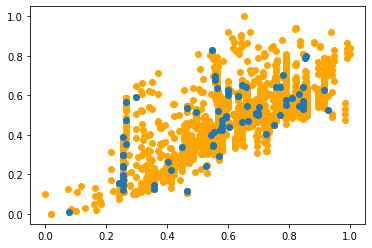

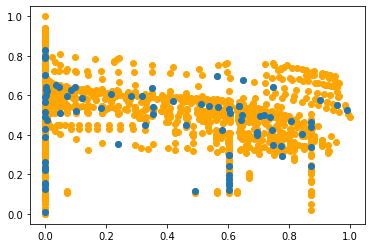

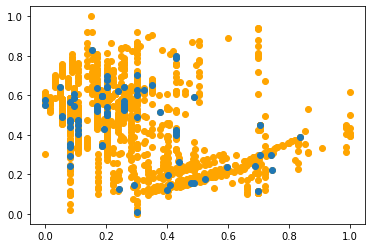

In [97]:
plt.scatter(M, yy, c = 'orange')
plt.scatter(M_test, y_test)

plt.figure()
plt.scatter(S, yy, c = 'orange')
plt.scatter(S_test, y_test)

plt.figure()
plt.scatter(T, yy, c = 'orange')
plt.scatter(T_test, y_test)

In [ ]:
models, history, gpr_models, gp_cv, NN_cv  = crossval_compare([create_ViscNN_concat], XX, yy, M=M, S=S, T=T, S_trans = S_trans, S_scaler = S_scaler, M_scaler = M_scaler, verbose = 1, gpr_model = create_GPR, epochs = 600)
np.savez(f'MODELS/{datetime.date.today()}_split/data', XX = XX, X_test = X_test, yy = yy, y_test = y_test, M = M, M_test = M_test, S = S, S_test = S_test, T = T, T_test = T_test)
train_df.to_pickle(f'MODELS/{datetime.date.today()}_split/train_data.pkl')
test_df.to_pickle(f'MODELS/{datetime.date.today()}_split/test_data.pkl')

In [ ]:
models_f, history_f, gpr_models_f, gp_cv_f, NN_cv = crossval_compare([create_ViscNN_concat], XX, yy, M=M, S=S, T=T, S_trans = S_trans, S_scaler = S_scaler, M_scaler = M_scaler, verbose = 1, gpr_model = create_GPR, epochs = 600, full_data = True)
train_df.to_pickle(f'MODELS/{datetime.date.today()}_full/train_data.pkl')

Reload Models

In [15]:
date = '2022-02-21'
models, history, gpr_models, gp_cv, NN_cv = load_models(date = date, data_type = 'split', NN_models = [create_ViscNN_concat])
#loaded_data = np.load(f'MODELS/{date}_split/data.npz', allow_pickle=True)
#XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test = loaded_data['XX'], loaded_data['X_test'], loaded_data['yy'], loaded_data['y_test'], loaded_data['M'], loaded_data['M_test'], loaded_data['S'], loaded_data['S_test'], loaded_data['T'],loaded_data['T_test']
model_reloaded = True

In [17]:
models_f, history_f, gpr_models_f, gp_cv, NN_cv = load_models(date = '2022-02-22', data_type = 'full', NN_models = [create_ViscNN_concat])
model_reloaded = True

In [18]:
model_num = 4

In [19]:
yy = y_scaler.inverse_transform(yy)
y_test = y_scaler.inverse_transform(y_test)

In [20]:
m_P = models[1][model_num]

test_pred, test_var,_ = predict_all_cv(models[1],[X_test, M_test, S_test, T_test])
train_pred, train_var,_ = predict_all_cv(models[1],[XX, M, S, T])
test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))
train_pred = y_scaler.inverse_transform(np.array(train_pred).reshape(-1, 1))
test_var = y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_
train_var = y_scaler.inverse_transform(np.array(train_var).reshape(-1, 1)) - y_scaler.data_min_

plt.errorbar(yy, list(train_pred.reshape(-1,)), yerr = list(np.array(train_var).reshape(-1,)), c = 'orange', fmt = 'o')
plt.errorbar(y_test , list(test_pred.reshape(-1,)), yerr= list(np.array(test_var).reshape(-1,)), fmt =  'o')

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(['Truth = Prediction','Train','Test'], loc = 'lower right')
plt.title('Physics Informed NN Parity Plot')

plt.text(-1.5, 9, r'$R^2$ = ' + "{:1.4f}".format(r2_score(test_pred, y_test)))
plt.text(-1.5, 8.5, r'Test OME = ' + "{:1.4f}".format((OME(y_test, test_pred).numpy())))
plt.text(-1.5, 8, r'Test MSE = ' + "{:1.4f}".format(mean_squared_error(y_test, test_pred)))
plt.text(-1.5, 7.5, r'CV MSE = ' + "{:1.4f}".format(get_CV_error(history[1], scaler= y_scaler)))
val_epochs(history[1], name = 'Physics Informed NN', scaler = y_scaler)

NameError: name 'models' is not defined

In [18]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
train_df[train_df['BAD_PRED'] == True].sort_index().to_excel('NP_Bad_pred_1_19_2022.xlsx')

NameError: name 'test_pred' is not defined

In [34]:
train_df

,afp_C4_C4_C4,afp_C4_C4_H1,afp_H1_C4_H1,bfp_267,bfp_282,bfp_289,bfp_304,bfp_315,bfp_334,bfp_349,...,Mw,Temperature,Shear_Rate,Melt_Viscosity,Polymer,SHEAR,ZERO_SHEAR,log_Shear_Rate,PDI,Sample_Type
1070,0.233333,1.066667,0.300000,0.000000,0.000000,0.900000,0.800000,0.000000,0.600000,0.600000,...,4.055378,178.139535,0.000000,0.775665,poly(decamethylene sebacate),0,1,0.000000,NaN,Homopolymer
1002,0.444444,1.111111,0.444444,0.444444,0.444444,0.333333,1.333333,0.222222,0.666667,0.666667,...,5.603144,170.000000,0.124199,5.285714,polypropylene,1,0,-0.905882,NaN,Homopolymer
707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.082192,0.000000,0.191781,0.356164,...,5.397940,275.000000,22.882535,6.347458,"poly{[bis(4-fluorophenyl) 1,4-phenylene diketo...",1,0,1.359504,NaN,Homopolymer
654,0.000000,0.181818,0.090909,0.000000,0.000000,0.272727,0.000000,0.000000,0.272727,0.363636,...,4.842609,280.000000,4000.000000,3.477121,poly(ethylene terephthalate),1,0,3.602060,NaN,Homopolymer
1499,0.064929,0.389571,0.129857,0.000000,0.000000,0.389571,0.194786,0.000000,0.324643,0.389571,...,4.348305,200.000000,1436.258806,3.397351,"poly[(butane-1,4-diol)-alt-(isophthalic acid)]...",1,0,3.157233,NaN,Copolymer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,0.200000,0.977778,0.288889,0.000000,0.000000,0.866667,0.733333,0.000000,0.577778,0.577778,...,3.301030,60.333333,60.000000,1.247685,poly(pentamethylene sebacate),1,0,1.778151,NaN,Homopolymer
35,0.333333,1.333333,0.333333,0.000000,0.000000,1.000000,1.000000,0.000000,0.666667,0.666667,...,5.751279,150.000000,0.000000,7.828164,Linear HDPE,0,1,0.000000,4.30,Homopolymer
138,0.125000,0.375000,0.062500,0.000000,0.250000,0.187500,0.750000,0.125000,0.375000,0.500000,...,3.633468,130.000000,0.000000,2.720332,polystyrene,0,1,0.000000,NaN,Homopolymer
1314,0.441956,1.116089,0.441956,0.434489,0.434489,0.348267,1.325867,0.217244,0.666667,0.666667,...,5.462398,270.000000,5.199334,4.683333,"poly(4-methyl-1-pentene), poly(1-decene)",1,0,0.715948,7.80,Copolymer


NameError: name 'history' is not defined

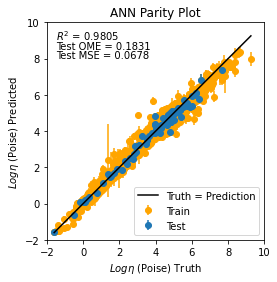

In [22]:
m_NP = models_f[0][model_num]
# test_pred =  m_NP.predict([X_test, M_test, S_test, T_test, gr_Mcr_test])
# train_pred = m_NP.predict([XX, M, S, T, gr_Mcr])
test_pred, test_var, _ = predict_all_cv(models_f[0],[X_test, M_test, S_test, T_test])
train_pred, train_var, _ = predict_all_cv(models_f[0],[XX, M, S, T])
test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))
train_pred = y_scaler.inverse_transform(np.array(train_pred).reshape(-1, 1))
test_var = y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_
train_var = y_scaler.inverse_transform(np.array(train_var).reshape(-1, 1)) - y_scaler.data_min_

plt.errorbar(yy, list(train_pred.reshape(-1,)), yerr = list(np.array(train_var).reshape(-1,)), c = 'orange', fmt = 'o')
plt.errorbar(y_test , list(test_pred.reshape(-1,)), yerr= list(np.array(test_var).reshape(-1,)), fmt =  'o')

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-', zorder = 10)
plt.ylabel(r'$Log \eta$ (Poise) Predicted')
plt.xlabel(r'$Log \eta$ (Poise) Truth')
plt.legend(['Truth = Prediction','Train','Test'], loc = 'lower right')
plt.title('ANN Parity Plot')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.text(-1.5, 9, r'$R^2$ = ' + "{:1.4f}".format(r2_score(test_pred, y_test)))
plt.text(-1.5, 8.5, r'Test OME = ' + "{:1.4f}".format((OME(y_test, test_pred).numpy())))
plt.text(-1.5, 8, r'Test MSE = ' + "{:1.4f}".format(mean_squared_error(y_test, test_pred)))
plt.text(-1.5, 7.5, r'CV MSE = ' + "{:1.4f}".format(get_CV_error(history[0], scaler= y_scaler)))
plt.text(-1.5, 7, r'CV OME = ' + "{:1.4f}".format(get_CV_error(NN_cv, scaler= y_scaler)))


val_epochs(history[0], name = 'ANN', scaler = y_scaler)
best_ANN = compare_cv(models[0], NN_cv, [X_test, M_test, S_test, T_test], y_test, scaler = y_scaler)


In [21]:
#gpr_model = train_GPR(XX, yy, M, S, T)
gpr_model = gpr_models[model_num]
model_reloaded = True

NameError: name 'gpr_models' is not defined

2022-02-22 10:06:48.035481: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7ea0470


<class 'numpy.float32'>


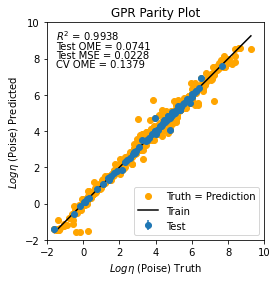

In [23]:
gpr_model = gpr_models_f[5] 
X_ = np.concatenate((X_test, M_test, S_test, T_test), axis = 1)
X_train = np.concatenate((XX, M, S, T), axis = 1)
test_pred, var = gpr_model.predict_f_compiled(tf.convert_to_tensor(X_, dtype=tf.float64))
train_pred, var_train = gpr_model.predict_f_compiled(X_train)
error =  [i[0] for i in np.array(var).tolist()]
test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))
train_pred = y_scaler.inverse_transform(np.array(train_pred).reshape(-1, 1))
var = y_scaler.inverse_transform(np.array(var).reshape(-1, 1)) - y_scaler.data_min_

high_var_test = np.where(np.array(var) > 10)
test_pred = np.delete(np.array(test_pred), high_var_test)
y_test_new = np.delete(np.array(y_test), high_var_test)
var = np.delete(np.array(var), high_var_test)
# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)

plt.scatter(yy, train_pred, c = 'orange')
plt.errorbar(y_test_new, test_pred, var, fmt = 'o')
plt.ylabel(r'$Log \eta$ (Poise) Predicted')
plt.xlabel(r'$Log \eta$ (Poise) Truth')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.legend(['Truth = Prediction', 'Train','Test'], loc = 'lower right')
plt.title('GPR Parity Plot')
plt.text(-1.5, 9, r'$R^2$ = ' + "{:1.4f}".format(r2_score(test_pred, y_test)))
plt.text(-1.5, 8.5, r'Test OME = ' + "{:1.4f}".format((OME(y_test.reshape(-1,), test_pred).numpy())))
plt.text(-1.5, 8, r'Test MSE = ' + "{:1.4f}".format(mean_squared_error(y_test, test_pred)))
plt.text(-1.5, 7.5, r'CV OME = ' + "{:1.4f}".format(get_CV_error(gp_cv, scaler= y_scaler)))
plt.show()

In [ ]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
test_df[test_df['BAD_PRED'] == True]
test_df.reset_index().loc[error.index(max(error))]

0.34246501152543185


,afp_C4_C4_C4,afp_C4_C4_H1,afp_H1_C4_H1,bfp_267,bfp_282,bfp_289,bfp_304,bfp_315,bfp_334,bfp_349,...,Temperature,Shear_Rate,Melt_Viscosity,Polymer,SHEAR,ZERO_SHEAR,log_Shear_Rate,Y_pred,Error,BAD_PRED
1544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.493218,0.570096,...,260.0,935.307371,2.139073,"Poly(hexano-6-lactam), PPTA",1,0,2.970954,2.845784,0.706711,True
261,0.266667,0.466667,0.466667,0.533333,0.000000,0.200000,1.400000,0.000000,0.533333,0.533333,...,220.0,89.526571,4.423077,poly(methyl methacrylate),1,0,1.951952,3.929518,0.493559,True
1165,0.149429,0.448286,0.074714,0.000000,0.298857,0.224143,0.896571,0.149429,0.448286,0.489143,...,200.0,0.097696,4.552494,"polystyrene, polyacrylonitrile",1,0,-1.010123,4.170946,0.381547,True
1089,0.134643,0.403929,0.067321,0.000000,0.269286,0.201964,0.807857,0.134643,0.403929,0.495714,...,170.0,0.000000,3.214844,"polystyrene, polyacrylonitrile",0,1,0.000000,3.880512,0.665668,True
194,0.125000,0.375000,0.062500,0.000000,0.250000,0.187500,0.750000,0.125000,0.375000,0.500000,...,200.0,548.441658,2.209302,polystyrene,1,0,2.739130,2.872448,0.663145,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0.181571,0.544714,0.090786,0.000000,0.363143,0.272357,1.089429,0.181571,0.544714,0.474857,...,200.0,0.390965,5.426735,"polystyrene, polyacrylonitrile",1,0,-0.407862,4.978222,0.448514,True
875,0.151515,0.484848,0.181818,0.000000,0.000000,0.545455,0.636364,0.000000,0.545455,0.363636,...,205.0,0.000000,3.399674,"poly[(2,2,3,3,4,4-hexafluoropentane-1,5-diol)-...",0,1,0.000000,3.810134,0.410461,True
183,0.333333,0.666667,0.166667,0.000000,0.000000,0.500000,1.000000,0.000000,0.666667,0.333333,...,210.0,0.000000,5.000000,poly(vinylidene fluoride),0,1,0.000000,5.585200,0.585200,True
1329,0.273810,0.821429,0.161905,0.033333,0.547619,0.410714,1.642857,0.273810,0.821429,0.435714,...,220.0,38.940893,3.532110,"polyacrylonitrile, Poly(methyl acrylate)",1,0,1.590406,4.012979,0.480869,True


In [114]:
Mw_samps, mw_ids = get_Mw_samples(train_df.copy().sort_index());
shear_samps, shear_ids = get_shear_samples(train_df.copy().sort_index())

/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


    index  afp_C4_C4_C4  afp_C4_C4_H1  afp_H1_C4_H1   bfp_267  bfp_282  \
0      84      0.583333      0.833333      0.583333  0.666667      0.0   
1      85      0.583333      0.833333      0.583333  0.666667      0.0   
2      86      0.583333      0.833333      0.583333  0.666667      0.0   
3      87      0.583333      0.833333      0.583333  0.666667      0.0   
4      88      0.583333      0.833333      0.583333  0.666667      0.0   
5      89      0.583333      0.833333      0.583333  0.666667      0.0   
6      90      0.583333      0.833333      0.583333  0.666667      0.0   
7      91      0.583333      0.833333      0.583333  0.666667      0.0   
8      92      0.583333      0.833333      0.583333  0.666667      0.0   
9      93      0.583333      0.833333      0.583333  0.666667      0.0   
10     94      0.583333      0.833333      0.583333  0.666667      0.0   

    bfp_289  bfp_304  bfp_315   bfp_334  ...  Shear_Rate  Melt_Viscosity  \
0      0.25     1.75      0.0  0.66

In [305]:
extrap_tests = Mw_test(Mw_samps, mw_ids[28])
XX_ex, OH, M_ex_og,S_ex_og,T_ex_og = extrap_tests['data_in']
#print(extrap_tests[samp_num]['tests'])
#Mw_ex = M_scaler.inverse_transform(np.array(extrap_tests['exp'][0]).reshape(-1, 1))
#log_visc_ex = y_scaler.inverse_transform(np.array(extrap_tests['exp'][1]).reshape(-1, 1))
Mw_ex = np.power(10,extrap_tests['exp'][0]) 
log_visc_ex = np.power(10,extrap_tests['exp'][1])
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform((XX_ex))
M_ex = M_scaler.transform(M_ex_og)
S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
T_ex = T_scaler.transform(1/(T_ex_og+273.15))
y_ax = (-2, 8)
temps = [-50, -20, 20, 50]

   index  afp_C4_C4_C4  afp_C4_C4_H1  afp_H1_C4_H1  bfp_267  bfp_282  bfp_289  \
0   1111           0.0           0.4           0.2      0.0      0.0      0.6   
1   1112           0.0           0.4           0.2      0.0      0.0      0.6   
2   1113           0.0           0.4           0.2      0.0      0.0      0.6   
3   1114           0.0           0.4           0.2      0.0      0.0      0.6   
4   1115           0.0           0.4           0.2      0.0      0.0      0.6   
5   1116           0.0           0.4           0.2      0.0      0.0      0.6   
6   1117           0.0           0.4           0.2      0.0      0.0      0.6   
7   1118           0.0           0.4           0.2      0.0      0.0      0.6   

   bfp_304  bfp_315  bfp_334  ...  Shear_Rate  Melt_Viscosity        Polymer  \
0      0.6      0.0      0.6  ...         0.0       -0.588922  polybutadiene   
1      0.6      0.0      0.6  ...         0.0       -0.249121  polybutadiene   
2      0.6      0.0      0.6  

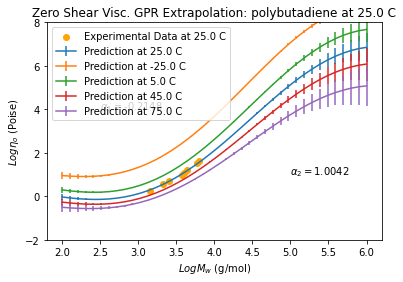

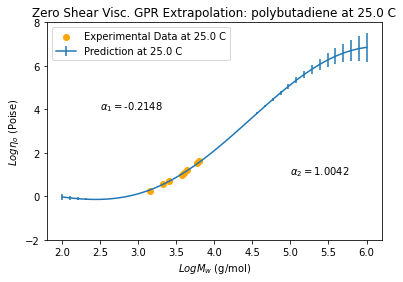

In [306]:
for temp_test in [True, False]:
    if model_reloaded:
        test_pred, var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_ex), axis = 1))
    else:
        test_pred, var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex, T_ex), axis = 1))

    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))
    var = y_scaler.inverse_transform(np.array(var).reshape(-1, 1)) - y_scaler.data_min_

    plt.figure()
    plt.xlabel(r'$Log M_w$ (g/mol)')
    plt.ylabel(r'$Log \eta_o$ (Poise)')
    plt.ylim(*y_ax)
    a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    plt.text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
    plt.text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
    plt.scatter(Mw_ex, log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    #plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
    #plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, [i[0] for i in np.array(var).tolist()], fmt = '-')
    plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), var.reshape(-1,), fmt = '-', label = f'Prediction at {T_ex_og[0][0]} C')

    if temp_test:
        for i in temps:
            test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i))), axis = 1))
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, yerr= test_var,  label = f'Prediction at {T_ex_og[0][0] + i} C')

    plt.title('Zero Shear Visc. GPR Extrapolation: ' + extrap_tests['sample'])
    plt.legend()
    plt.show()


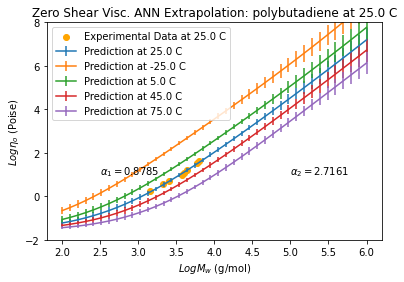

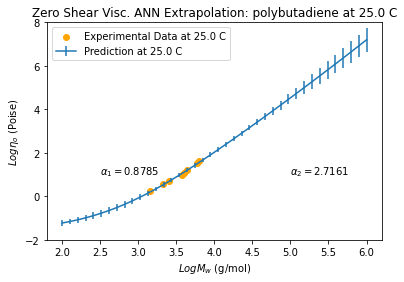

In [307]:
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
for temp_test in [True, False]:
    test_pred, test_var,_ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_ex])

    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)


    plt.figure()
    plt.title('Zero Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'])
    plt.xlabel(r'$Log M_w$ (g/mol)')
    plt.ylabel(r'$Log \eta_o$ (Poise)')
    a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    plt.text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
    plt.text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
    plt.scatter(Mw_ex, log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    plt.ylim(*y_ax)
    #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
    plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')

    if temp_test:
        for i in temps:
            test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i))])
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, yerr= test_var,  label = f'Prediction at {T_ex_og[0][0] + i} C')


    plt.legend()

In [83]:
#test_pred = m_P.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
test_pred, test_var, tot_pred = predict_all_cv(models_f[1],[XX_ex, M_ex, S_ex, T_ex])

test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)

plt.figure()
plt.title('Zero Shear Visc. Physics NN Extrapolation')
plt.xlabel('Log Mw (g/mol)')
plt.ylabel(r'$Log \eta_o$ (Poise)')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var)
a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
plt.text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
plt.text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
plt.ylim(-3, 10)
plt.legend(['Experimental','Predicted'])
#plt.plot([4,6], [2.5, 2.5+(3.4*2)])
#print(k_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
#print(tau_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
#print(alpha_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
#print(n_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))

NameError: name 'models_f' is not defined

In [145]:
data_mod = filtered_data.copy()
new_fp = []
for c in train_df.columns:
    if isinstance(c, str):
        if 'fp' in c:
            new_fp.append(c)

if len(OG_fp) != len(new_fp):
    data_mod = data_mod.drop(columns = list(set(OG_fp) - set(new_fp)))
for c in ['Mw', 'Melt_Viscosity']:
    data_mod[c] = np.power(10, data_mod[c])

shear_samps, shear_ids = get_shear_samples(data_mod)


In [146]:
shear_samps['Mw']

212     5.374748
213     5.374748
214     5.374748
215     5.374748
216     5.374748
          ...   
1612    4.285107
1613    4.285107
1614    4.285107
1615    4.285107
1616    4.285107
Name: Mw, Length: 963, dtype: float64

In [325]:
do_pca = False
samp_num = shear_ids[5]
s_test = shear_test(shear_samps, samp_num)
XX_ex, M_ex_og,S_ex,T_ex_og = s_test['data_in']
shear_exp = s_test['known'][0]
log_visc_exp = np.power(10,s_test['known'][1])
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform(((XX_ex)))
M_ex = M_scaler.transform(np.power(10, M_ex_og))
S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
T_ex = T_scaler.transform(1/(T_ex_og+273.15))
y_ax = (3,5)
temps = [-50, -20, 20, 50]

    index  afp_C4_C4_C4  afp_C4_C4_H1  afp_H1_C4_H1  bfp_267  bfp_282  \
0     327           0.0           0.0           0.0      0.0      0.0   
1     328           0.0           0.0           0.0      0.0      0.0   
2     329           0.0           0.0           0.0      0.0      0.0   
3     330           0.0           0.0           0.0      0.0      0.0   
4     331           0.0           0.0           0.0      0.0      0.0   
5     332           0.0           0.0           0.0      0.0      0.0   
6     333           0.0           0.0           0.0      0.0      0.0   
7     334           0.0           0.0           0.0      0.0      0.0   
8     335           0.0           0.0           0.0      0.0      0.0   
9     336           0.0           0.0           0.0      0.0      0.0   
10    337           0.0           0.0           0.0      0.0      0.0   
11    338           0.0           0.0           0.0      0.0      0.0   
12    339           0.0           0.0           0.0

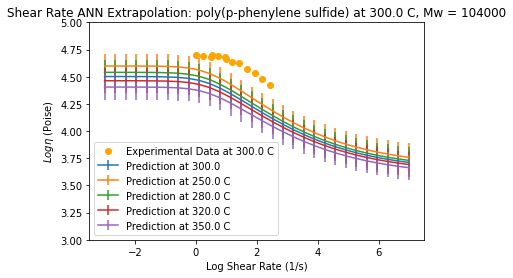

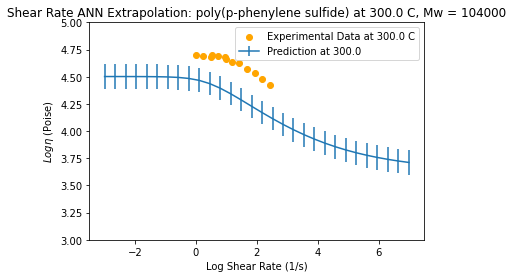

In [326]:
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
for temp_test in [True, False]:
    test_pred, test_var,_ = predict_all_cv(models_f[0], [XX_ex, M_ex, S_ex_trans, T_ex])
    shear = [s[0] for s in np.log10(S_ex)]

    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)

    plt.figure()
    plt.errorbar(shear, test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]}')
    plt.title('Shear Rate ANN Extrapolation: ' + s_test['sample'])

    if temp_test:
        for i in temps:
            test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex_trans, T_scaler.transform(1/(T_ex_og +273.15 + i))])
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            plt.errorbar(shear, test_pred, yerr= test_var,  label = f'Prediction at {T_ex_og[0][0] + i} C')
    plt.xlabel('Log Shear Rate (1/s)')
    plt.ylabel(r'$Log \eta$ (Poise)')
    plt.scatter(shear_exp, log_visc_exp, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')

    plt.legend()
    plt.ylim(*y_ax)

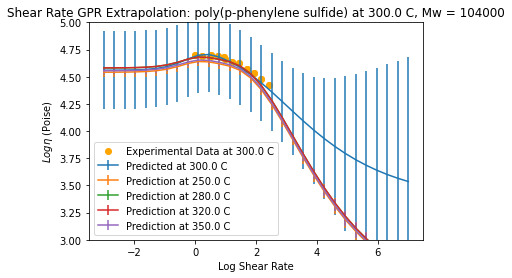

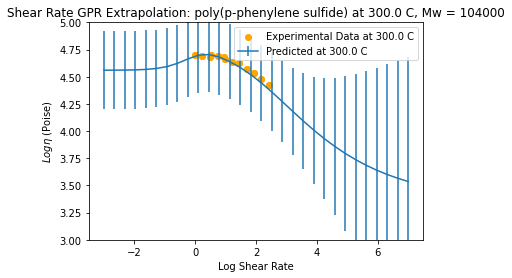

In [330]:
#test_pred, test_var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
for temp_test in [True, False]:
    if model_reloaded:
        test_pred, var = gpr_models_f[1].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
    else:
        test_pred, var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)



    plt.figure()

    plt.errorbar(shear, test_pred, yerr= var, label = f'Predicted at {T_ex_og[0][0]} C')
    if temp_test:
        for i in temps:
            test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex_trans, T_scaler.transform(1/(T_ex_og +273.15 + i))), axis = 1))
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            plt.errorbar(shear, test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0] + i} C')

    plt.xlabel('Log Shear Rate (1/s)')
    plt.ylabel(r'$Log \eta$ (Poise)')
    plt.scatter(shear_exp, log_visc_exp, c = 'orange')




    plt.title('Shear Rate GPR Extrapolation: '+ s_test['sample'])

    plt.xlabel('Log Shear Rate')
    plt.ylabel(r'$Log \eta$ (Poise)')
    plt.scatter(shear_exp, log_visc_exp, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    plt.ylim(*y_ax)
    plt.legend()

In [144]:
#test_pred = m_P.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
test_pred, test_var,_ = predict_all_cv(models_f[1],[XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in np.log10(S_ex)]

test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
if temp_test:
    for i in [1,3,5]:
        test_pred, test_var,_ = predict_all_cv(models_f[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]])])
        test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
        test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Log Shear Rate (1/s)')
plt.ylabel(r'$Log \eta$ (Poise)')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
#plt.plot(np.log10(S_ex[:-1]), test_pred[:-1])
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
     plt.legend(['Experimental','Predicted'])
plt.title('Physics NN Extrapolation')
plt.ylim(*y_ax)

plt.figure()
plt.scatter(shear_exp, log_visc_exp, c = 'orange')

#print(params_layer([XX_ex, M_ex, S_ex_trans, T_ex]))
#z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex])
#print(crit_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(tau_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(n_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))

NameError: name 'models' is not defined

Shear with Low and Zero Shear Rates

In [358]:
low_shear_samps = shear_samps.copy()
for samp in shear_ids:
    if np.prod(low_shear_samps.loc[low_shear_samps['SAMPLE_ID'] == samp, 'Shear_Rate']) != 0:
        low_shear_samps = low_shear_samps.drop(low_shear_samps.loc[low_shear_samps['SAMPLE_ID'] == samp].index, axis = 0)
low_shear_ids = list(low_shear_samps.agg({'SAMPLE_ID': 'unique'})[0])

In [359]:
low_shear_samps.index

Int64Index([ 341,  342,  343,  344,  345,  346,  347,  348,  349,  350,
            ...
            1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358],
           dtype='int64', length=143)

In [379]:
samp_num = low_shear_ids[4]
s_test = small_shear_test(low_shear_samps, samp_num)
XX_ex, M_ex,S_ex,T_ex = s_test['data_in']
shear_exp = s_test['known'][0]
log_visc_exp = np.power(10,s_test['known'][1])
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform(((XX_ex)))
M_ex = M_scaler.transform(np.power(10, M_ex))
S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
T_ex = T_scaler.transform(1/(T_ex+273.15))
temp_test = False
y_ax = (1,4)

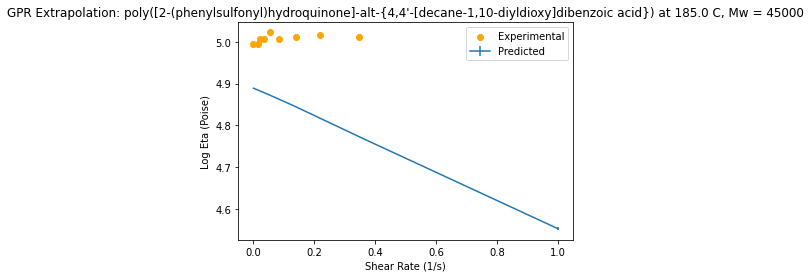

In [382]:
test_pred, test_var = gpr_models_f[3].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
shear = [s[0] for s in S_ex]

test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)

plt.figure()
plt.title('GPR Extrapolation: ' + s_test['sample'])
plt.errorbar(shear, np.array(test_pred).tolist(), yerr= np.array(test_var).tolist()) #[i[0] for i in np.array(test_var).tolist()]
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange')
plt.legend(['Experimental','Predicted'])

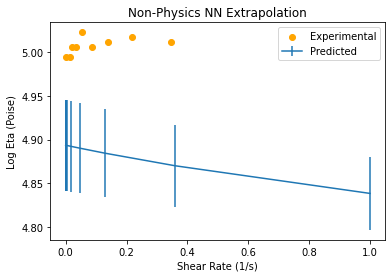

In [381]:
test_pred, test_var,_ = predict_all_cv(models_f[0], [XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in S_ex]

test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)


plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
plt.title('Non-Physics NN Extrapolation')

# if temp_test:
#     for i in [1,3,5]:
#         test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
#         plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange')
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
    plt.legend(['Experimental','Predicted'])

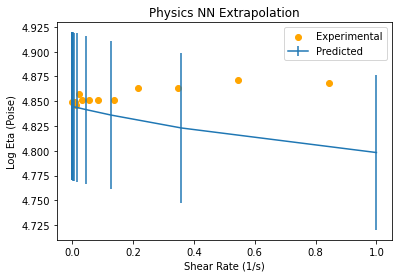

In [367]:
test_pred, test_var,_ = predict_all_cv(models[1], [XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in S_ex]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
plt.title('Physics NN Extrapolation')

if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange')
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
    plt.legend(['Experimental','Predicted'])

Holistic Model Performance

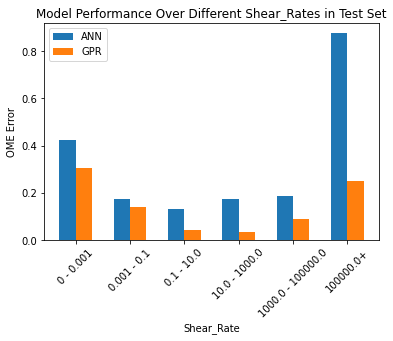

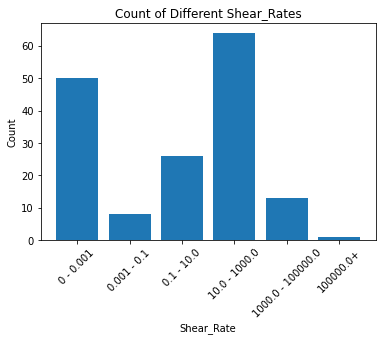

In [106]:
metric = 'Shear_Rate'
buckets = [0, 1e-3, 1e-1, 1e1, 1e3, 1e5]
ANN_error = []
physNN_error = []
gpr_error = []
samp_counts = []
total_data = False

if total_data:
    selected_data_init = filtered_data.copy()
else:
    selected_data_init = test_df

for i in range(len(buckets)):  
    if isinstance(buckets[0], str):
        selected_data = selected_data_init.loc[selected_data_init[metric] == buckets[i]]
    else:
        if i == len(buckets) - 1:
            selected_data = selected_data_init.loc[selected_data_init[metric] >= buckets[i]]
        else:
            selected_data = selected_data_init.loc[selected_data_init[metric].between(buckets[i], buckets[i+1])]
    #print(buckets[i])
    #print(selected_data)
    X_s = np.array(scaler.transform(selected_data.filter(fp_cols)))
    samp_counts.append(X_s.shape[0])
    Y_s = np.array(selected_data.loc[:,'Melt_Viscosity']).reshape((-1,1))

    logMw = np.array(selected_data['Mw']).reshape((-1,1))
    shear = np.array(selected_data['Shear_Rate']).reshape((-1,1))
    Temp = np.array(selected_data['Temperature']).reshape((-1,1))
    Temp = 1/(Temp+273.15)

    #Y_s = y_scaler.transform(Y_s)
    Temp = T_scaler.transform(Temp)
    logMw = M_scaler.transform(logMw)
    shear = S_scaler.transform(S_trans.transform(shear))
    #print([X_s, logMw, shear, Temp])
    ANN_pred = y_scaler.inverse_transform(np.array(predict_all_cv(models[0], [X_s, logMw, shear, Temp])[0]).reshape(-1, 1))
    #physNN_pred = y_scaler.inverse_transform(np.array(predict_all_cv(models[1], [X_s, logMw, shear, Temp])[0]).reshape(-1, 1))
    gpr_pred = y_scaler.inverse_transform(gpr_models[3].predict_f_compiled(np.concatenate((X_s, logMw, shear, Temp), axis = 1))[0].numpy().reshape(-1, 1))

    ANN_error.append(OME(Y_s, ANN_pred))
    #print(Y_s, ANN_pred.shape)
    #physNN_error.append(OME(Y_s, physNN_pred))
    gpr_error.append(OME(Y_s, gpr_pred))

X_axis = np.arange(len(buckets))
plt.bar(X_axis - 0.15, ANN_error, 0.3, label = 'ANN')
#plt.bar(X_axis -0.1, physNN_error, 0.2, label = 'PhysNN')
plt.bar(X_axis + 0.15, gpr_error, 0.3, label = 'GPR')


if isinstance(buckets[0], str):
    plt.xticks(X_axis, buckets, rotation = 45)
else:
    plt.xticks(X_axis, [f'{buckets[i]} - {buckets[i+1]}' for i in range(len(buckets) - 1)] + [f'{buckets[-1]}+'], rotation = 45)


plt.xlabel(metric)
plt.ylabel("OME Error")
plt.title(f'Model Performance Over Different {metric}s in Test Set')
plt.legend()
plt.show()

plt.figure()
plt.bar(X_axis, samp_counts)
if isinstance(buckets[0], str):
    plt.xticks(X_axis, buckets, rotation = 45)
else:
    plt.xticks(X_axis, [f'{buckets[i]} - {buckets[i+1]}' for i in range(len(buckets) - 1)] + [f'{buckets[-1]}+'], rotation = 45)
plt.xlabel(metric)
plt.ylabel("Count")
plt.title(f'Count of Different {metric}s')
plt.show()

In [26]:
filtered_data.loc[filtered_data['Polymer'] == 'poly(prop-1-ene)']

,afp_C4_C4_C4,afp_C4_C4_H1,afp_H1_C4_H1,bfp_267,bfp_282,bfp_289,bfp_304,bfp_315,bfp_334,bfp_349,...,Mw,Temperature,Shear_Rate,Melt_Viscosity,Polymer,SHEAR,ZERO_SHEAR,log_Shear_Rate,PDI,Sample_Type


In [96]:
gpr_Mcr = create_GPR(X_me, y)

In [17]:
tf.saved_model.save(gpr_Mcr, 'models')

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [18]:
gpr = tf.saved_model.load('models')

In [ ]:
gpr.predict_y(x_me)

In [24]:
trial_scale = MinMaxScaler(copy = False)

In [97]:
isinstance([1,2,3][0], int)

True

In [26]:
trial_scale.fit(arr).transform(arr)

array([[0., 0., 0.],
       [0., 1., 1.]])